#Подключаем библиотеки и загружаем данные

In [1]:
!pip install catboost

     |████████████████████████████████| 64.8MB 57kB/s 


In [2]:
from sklearn import ensemble, model_selection, datasets, metrics, tree, linear_model, preprocessing 
from sklearn.neural_network import MLPRegressor

from catboost import CatBoostRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import lightgbm as lgb

import xgboost as xgb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Данные по заражениям

In [3]:
!git clone https://github.com/CSSEGISandData/COVID-19 -b web-data COVID-19-new

Cloning into 'COVID-19-new'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 22625 (delta 0), reused 2 (delta 0), pack-reused 22618
Receiving objects: 100% (22625/22625), 98.65 MiB | 25.07 MiB/s, done.
Resolving deltas: 100% (12257/12257), done.


In [4]:
!git clone https://github.com/CSSEGISandData/COVID-19.git


Cloning into 'COVID-19'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 22625 (delta 0), reused 2 (delta 0), pack-reused 22618
Receiving objects: 100% (22625/22625), 98.65 MiB | 29.54 MiB/s, done.
Resolving deltas: 100% (12257/12257), done.


In [5]:
!git clone https://github.com/grwlf/COVID-19_plus_Russia.git

Cloning into 'COVID-19_plus_Russia'...
remote: Enumerating objects: 17561, done.
remote: Total 17561 (delta 0), reused 0 (delta 0), pack-reused 17561
Receiving objects: 100% (17561/17561), 83.28 MiB | 28.11 MiB/s, done.
Resolving deltas: 100% (8924/8924), done.


## Данные про страны

In [6]:
!git clone https://github.com/vlomme/sberbank-covid19-forecast-2020.git

Cloning into 'sberbank-covid19-forecast-2020'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 238 (delta 28), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (238/238), 7.53 MiB | 10.64 MiB/s, done.
Resolving deltas: 100% (122/122), done.


## Данные по карантинам

In [7]:
!git clone https://github.com/tyz910/sberbank-covid19.git

Cloning into 'sberbank-covid19'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 160 (delta 73), reused 143 (delta 56), pack-reused 0
Receiving objects: 100% (160/160), 1.17 MiB | 2.84 MiB/s, done.
Resolving deltas: 100% (73/73), done.


## Загружаем данные

In [0]:
today = pd.to_datetime('today').strftime("%Y-%m-%d")
#Загрузить список стран и удалить лишние атрибуты 
countries = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/countries.csv")
countries.drop(['iso_alpha2','iso_numeric','official_name','name'], axis='columns',inplace=True)

#Загрузить список регионов
regions = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/russia_regions.csv")
regions = regions[["iso_code","csse_province_state","csse_province_state2","population","population_urban"]]
regions.population_urban = regions.population_urban/regions.population
regions.rename(columns={"iso_code": "iso_alpha3","csse_province_state":"ccse_name","csse_province_state2":"ccse_name2","population_urban":"urban_pop_rate"},inplace=True)

regions_info = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/regions-info.csv", decimal=",")
regions_info = regions_info[["Region_eng","Density_pop_sqkm","Area"]]
regions_info.rename(columns={"Region_eng": "ccse_name2","Area": "land_area","Density_pop_sqkm": "density"},inplace=True)
regions= regions.merge(regions_info, how = 'left', left_on='ccse_name2', right_on='ccse_name2')

#Загрузить данные заражений по России
data_Ru = pd.read_csv("/content/COVID-19_plus_Russia/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_RU.csv").groupby("Province_State").sum()
data_Ru = data_Ru.iloc[:,15:].stack().reset_index()
data_Ru.columns = ["countries","date","confirmed"]
#Загрузить данные смертей по России
data_deaths_Ru = pd.read_csv("/content/COVID-19_plus_Russia/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_RU.csv").groupby("Province_State").sum()
data_deaths_Ru = data_deaths_Ru.iloc[:,15:].stack().reset_index()
data_deaths_Ru.columns = ["countries","date","deaths"]
data_Ru = data_Ru.merge(data_deaths_Ru, how = 'left', left_on=('countries','date'), right_on=('countries','date'))
data_Ru["recovered"] = 0

data_Ru_today = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/covid19-russia-cases.csv")
data_Ru_today = data_Ru_today[data_Ru_today['Region/City-Eng']!="Diamond Princess"]
data_Ru_today = data_Ru_today[["Region/City-Eng","Date","Confirmed",	"Deaths",	"Recovered"]]
data_Ru_today.columns = ["countries","date","confirmed","deaths","recovered"]
data_Ru_today = data_Ru_today[data_Ru_today.date == today]
data_Ru_today = data_Ru_today.replace(regions.ccse_name2.to_list(), regions.ccse_name.to_list())
data_Ru = pd.concat([data_Ru, data_Ru_today])
regions.drop(['ccse_name2'], axis='columns',inplace=True)
countries = pd.concat([countries, regions])

#Загрузить USA
data_USA = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
data_USA = data_USA.groupby("Province_State").sum()
data_USA = data_USA.iloc[:,5:].stack().reset_index()
data_USA.columns = ["countries","date","confirmed"]

data_USA_deaths = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
data_USA_deaths = data_USA_deaths.groupby("Province_State").sum()
data_USA_deaths = data_USA_deaths.iloc[:,5:].stack().reset_index()
data_USA_deaths.columns = ["countries","date","deaths"]
data_USA = data_USA.merge(data_USA_deaths, how = 'left', left_on=('countries','date'), right_on=('countries','date'))
data_USA["recovered"] = 0
data_USA.loc[data_USA.countries =="Georgia","countries"] = "Georgia2"
USA = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/USA.csv")
USA["iso_alpha3"] = "USA_" + USA["ccse_name"]
USA["urban_pop_rate"] = USA["urban_pop_rate"]/100
countries = pd.concat([countries, USA])


#Загрузить список стран c датами
data_ans = pd.read_csv("/content/sberbank-covid19-forecast-2020/sample_submission.csv").iloc[:,:-1]
data_ans["confirmed"] = -1
data_ans = data_ans.merge(countries, how = 'left', left_on='region', right_on='iso_alpha3')
data_ans = data_ans[["date","ccse_name","confirmed"]]
data_ans = data_ans.rename(columns={"ccse_name": "countries"})
data_ans["deaths"] = 0
data_ans["recovered"] = 0
data_ans = data_ans[data_ans.date >= today]

#Загрузить данные заражений по миру
data = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
data = data.groupby("Country/Region").sum()

#Загрузить данные смертей по миру
data_deaths = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data_deaths = data_deaths.groupby("Country/Region").sum()


#Каждый день на новой строке
data_deaths = data_deaths.iloc[:,4:].stack().reset_index()
data_deaths.columns = ["countries","date","deaths"]

#Загрузить данные смертей по миру
data_recovered = pd.read_csv("/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
data_recovered = data_recovered.groupby("Country/Region").sum()
data_recovered = data_recovered.iloc[:,4:].stack().reset_index()
data_recovered.columns = ["countries","date","recovered"]
data_recovered["recovered"] = np.log10(data_recovered["recovered"]+1)

#Карантин
data_quarantine = pd.read_csv("/content/sberbank-covid19/data/quarantine.csv")
data_quarantine = data_quarantine.groupby("country").max().loc[:,"date"]
countries = countries.set_index("iso_alpha3", drop=False)
countries["Quarantine"] = data_quarantine
countries = countries.rename(columns={"ccse_name": "countries"})
dic_countries = dict(zip(countries.iso_alpha3.to_list(), countries.countries.to_list()))

# Сегоднящние данные
countries_today = pd.read_csv("/content/COVID-19-new/data/cases_country.csv")
countries_today["Last_Update"] = pd.to_datetime(countries_today["Last_Update"]).apply(lambda x: pd.Series(x.strftime("%Y-%m-%d")))
countries_today = countries_today[["Country_Region","Last_Update","Confirmed","Deaths","Recovered"]]
countries_today.columns = ['countries', 'date', 'confirmed', 'deaths', 'recovered']
countries_today.recovered =  np.log10(countries_today["recovered"]+1)
countries_today = countries_today[countries_today.countries.isin(countries.countries.to_list())]
countries_today = countries_today.sort_values(by='countries')

#Здравохранение
Health_systems = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/2.12_Health_systems.csv").groupby("Country_Region").mean()
Health_systems = Health_systems.fillna(Health_systems.mean())
Health_systems = Health_systems[["Health_exp_pct_GDP_2016","Health_exp_per_capita_USD_2016","Physicians_per_1000_2009-18","Nurse_midwife_per_1000_2009-18"]]
Health_systems.columns = ["Health_GDP","Health_USD","Physicians","Nurse"]
countries = countries.merge(Health_systems, how = 'left', left_on='countries', right_on='Country_Region')

#Возраст
WorldPop = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/WorldPopulationByAge2020.csv")
WorldPop = WorldPop.fillna(WorldPop.mean())
WorldPop2 = (WorldPop[WorldPop["AgeGrp"]=="60+"]["PopTotal"].to_numpy() + WorldPop[WorldPop["AgeGrp"]=="40-59"]["PopTotal"].to_numpy())/(WorldPop[WorldPop["AgeGrp"]=="0-19"]["PopTotal"].to_numpy()+WorldPop[WorldPop["AgeGrp"]=="20-39"]["PopTotal"].to_numpy())
WorldPop = WorldPop.groupby("Location").mean()
WorldPop["Age_old/new"] = WorldPop2
WorldPop = WorldPop[["Age_old/new"]].reset_index()
countries = countries.merge(WorldPop, how = 'left', left_on='countries', right_on='Location')

#Курение
smoke = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/share-of-adults-who-smoke.csv")
smoke = smoke[smoke.Year > 2015].groupby("Entity").mean()
smoke = smoke[["Smoking prevalence, total (ages 15+) (% of adults)"]]
smoke.columns = ["Smoking"]
smoke = smoke.reset_index()
countries= countries.merge(smoke, how = 'left', left_on='countries', right_on='Entity')
countries.drop(['Entity','Location'], axis='columns',inplace=True)

#Еще инфа о странах
countries2 = pd.read_csv("/content/sberbank-covid19-forecast-2020/data/covid19countryinfo.csv")
countries2 = countries2.fillna(0).groupby("country").sum()
countries2 = countries2[["tests","testpop","gatheringlimit","hospibed","healthperpop"]]
countries = countries.merge(countries2, how = 'left', left_on='countries', right_on='country')


countries["region"] = 0
countries.loc[countries.iso_alpha3.str.contains('-'),"region"] = 1
countries.loc[countries.iso_alpha3.str.contains('USA_'),"region"] = 2

#mobility-google
mobility = pd.read_csv("/content/sberbank-covid19/data/mobility-google.csv")
mobility.columns = ["country","date","Parks","Residential","Retail & recreation","Transit stations","Workplaces","Grocery & pharmacy"]
mobility["date"] = pd.to_datetime(mobility.date)

mobility_apple = pd.read_csv("/content/sberbank-covid19/data/mobility-apple.csv")
mobility_apple.drop(['apl-transit'], axis='columns',inplace=True)
mobility_apple.columns = ["date", "country", "driving", "walking"]
mobility_apple["date"] = pd.to_datetime(mobility_apple.date)

mobility_yandex = pd.read_csv("/content/sberbank-covid19/data/mobility-yandex.csv")
mobility_yandex["date"] = pd.to_datetime(mobility_yandex.date)

In [0]:
# Избавляемся от Nan
countries_mean = countries.mean()
countries[countries.region==2] = countries[countries.region==2].fillna(countries[countries.iso_alpha3 == "USA"].to_dict('records')[0])
countries[countries.region==1] = countries[countries.region==1].fillna(countries[countries.iso_alpha3 == "RUS"].to_dict('records')[0])
countries.loc[countries.tests == 0,"tests"] = countries.tests.mean()
countries.loc[countries.testpop == 0,"testpop"] = countries.testpop.mean()
countries.loc[countries.gatheringlimit == 0,"gatheringlimit"] = countries.gatheringlimit.mean()
countries.loc[countries.hospibed == 0,"hospibed"] = countries.hospibed.mean()
countries['Quarantine'] = countries['Quarantine'].fillna("2020-04-10")
countries = countries.fillna(countries_mean.to_dict())

## Смотрим на первые страны

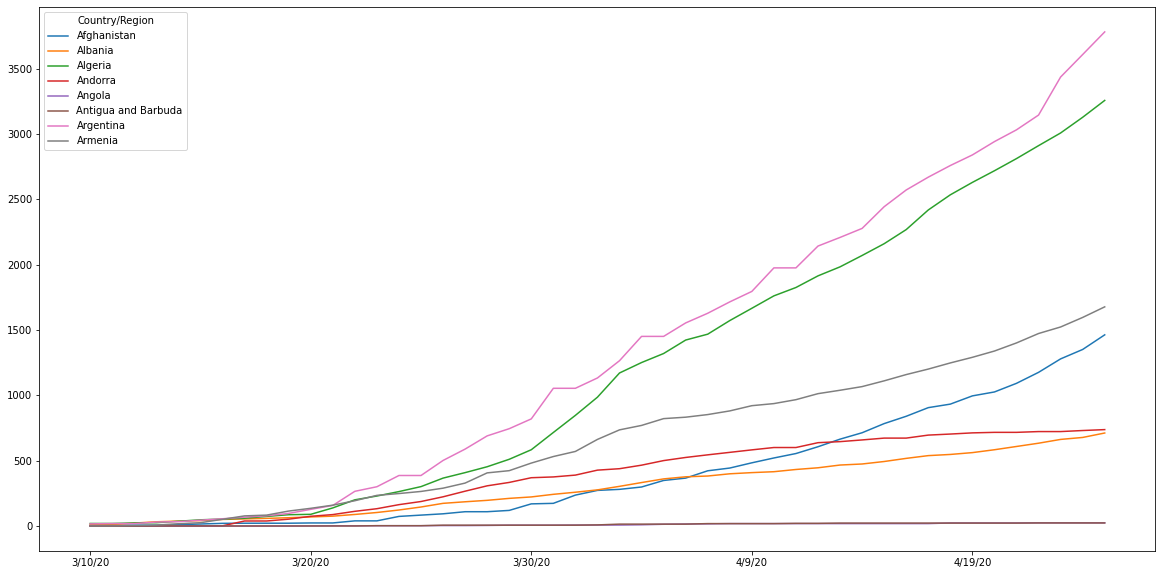

In [10]:
plt.rcParams['figure.figsize'] = [20, 10]
data.iloc[:8].T.iloc[50:].plot()

# Обрабатываем данные

## Представляем данные в виде, где каждой дате соответствует свой столбец

In [0]:
data2 = data.iloc[:,4:].stack().reset_index()
data2.columns = ["countries","date","confirmed"]

#Соединим смерти и заражения
data2 = data2.merge(data_deaths, how = 'left', left_on=('countries','date'), right_on=('countries','date'))

# Добавим выздоровивших
data2 = data2.merge(data_recovered, how = 'left', left_on=('countries','date'), right_on=('countries','date'))
data2 = data2[data2.countries.isin(countries.countries.to_list())]

#Объединим с сегодня
last_confirmed = data2.loc[pd.to_datetime(data2.date) == pd.to_datetime(today) - pd.offsets.Day(1)].sort_values(by='countries')
countries_today_new = countries_today[countries_today.confirmed.values > last_confirmed.confirmed.values]
data2 = pd.concat([data2, countries_today_new],ignore_index=True)

#Добавим Россию
data2 = pd.concat([data2, data_Ru],ignore_index=True)

#Добавим USA
data2 = pd.concat([data2, data_USA],ignore_index=True)

#Объединим с будущим
data_ans = data_ans[(data_ans.date != today)|(~(data_ans.countries.isin(countries_today_new.countries.values))&~(data_ans.countries.isin(data_Ru_today.countries.values)))]
data2 = pd.concat([data2, data_ans],ignore_index=True)


#Добавим информацию о стране(плотность, население и тд)
data2 = data2.merge(countries, how = 'right', left_on='countries', right_on='countries')

#Удалим дни без больных
data2 = data2[data2.confirmed != 0]
data2.loc[data2.confirmed == -1,"confirmed"] = 0


data2["date"] = pd.to_datetime(data2.date)


data2 = data2.merge(mobility_yandex, how = 'left', left_on=('iso_alpha3','date'), right_on=('country','date'))
mobility_min = mobility_yandex.groupby("country").min().drop(['date'], axis='columns')
mobility_min.columns = ['min_isolation']
data2 = data2.merge(mobility_min, how = 'left', left_on='iso_alpha3', right_on='country')
data2.loc[(data2.isolation.isnull())&(data2.date>pd.to_datetime("2020-04-01")),
          'isolation'] = data2.loc[(data2.isolation.isnull())&(data2.date>pd.to_datetime("2020-04-01")),'min_isolation'].to_numpy()
data2.drop(['country', 'min_isolation'], axis='columns',inplace=True)
#data2['isolation'] = data2['isolation'].fillna(data2['isolation'].mean())
data2['isolation'] = (data2['isolation'])/5


data2 = data2.merge(mobility_apple, how = 'left', left_on=('iso_alpha3','date'), right_on=('country','date'))
mobility_min = mobility_apple.groupby("country").min().drop(['date'], axis='columns')
mobility_min.columns = ['min_driving', 'min_walking']
data2 = data2.merge(mobility_min, how = 'left', left_on='iso_alpha3', right_on='country')
data2.loc[(data2.driving.isnull())&(data2.date>pd.to_datetime("2020-04-01")),
          ['driving', 'walking']] = data2.loc[(data2.driving.isnull())&(data2.date>pd.to_datetime("2020-04-01")),['min_driving', 'min_walking']].to_numpy()
data2.drop(['country', 'min_driving', 'min_walking'], axis='columns',inplace=True)
#data2.loc[data2.region==2,['driving', 'walking']] = data2.loc[data2.region==2,['driving', 'walking']].fillna(data2.loc[data2.iso_alpha3 == "USA",['driving', 'walking']].to_dict('records')[0])
#data2.loc[data2.region==1,['driving', 'walking']] = data2.loc[data2.region==1,['driving', 'walking']].fillna(data2.loc[data2.iso_alpha3 == "RUS",['driving', 'walking']].to_dict('records')[0])
#data2[['driving', 'walking']] = data2[['driving', 'walking']].fillna(data2[['driving', 'walking']].mean())
data2.loc[data2.region != 1,'isolation'] = (data2['driving'] +  data2['walking'])/100


data2 = data2.merge(mobility, how = 'left', left_on=('iso_alpha3','date'), right_on=('country','date'))
mobility_min = mobility.groupby("country").min().drop(['date'], axis='columns')
mobility_min.columns = ['min_Retail & recreation', 'min_Grocery & pharmacy', 'min_Parks',
       'min_Transit stations', 'min_Workplaces', 'min_Residential']
data2 = data2.merge(mobility_min, how = 'left', left_on='iso_alpha3', right_on='country')
data2.loc[(data2.Parks.isnull())&(data2.date>pd.to_datetime("2020-04-01")),
          ['Retail & recreation', 'Grocery & pharmacy', 'Parks', 'Transit stations', 'Workplaces', 
           'Residential']] = data2.loc[(data2.Parks.isnull())&(data2.date>pd.to_datetime("2020-04-01")),
                                       ['min_Retail & recreation', 'min_Grocery & pharmacy', 'min_Parks',
       'min_Transit stations', 'min_Workplaces', 'min_Residential']].to_numpy()
data2.drop(['country', 'min_Retail & recreation', 'min_Grocery & pharmacy', 'min_Parks',
       'min_Transit stations', 'min_Workplaces', 'min_Residential'], axis='columns',inplace=True)
"""data2[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']] = data2[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']].fillna(data2[['Retail & recreation', 'Grocery & pharmacy', 'Parks',
       'Transit stations', 'Workplaces', 'Residential']].mean())"""
data2.loc[data2.isolation.isnull(),'isolation'] = (data2['Retail & recreation'] +data2['Grocery & pharmacy'] +data2[ 'Parks'] 
                                                   +data2['Transit stations'] +data2[ 'Workplaces'] +data2[ 'Residential']+500)/1000     

data2['isolation'] = data2['isolation'].fillna(data2['isolation'].mean())

In [0]:
log_labels = True

if log_labels:
  data2.confirmed = np.log10(data2.confirmed+1)
  data2.deaths = np.log10(data2.deaths+1)
else:
  data2.confirmed = data2.confirmed/10**4
  data2.deaths = data2.deaths/10**3

## Добавить данные за прошлый день

In [0]:
old_con = data2["confirmed"].iloc[:-1]
old_con2 = data2["deaths"].iloc[:-1]
old_recovered = data2["recovered"].iloc[:-1]
data2 = data2.iloc[1:]
data2["pred_conf"] = old_con.values
data2["pred_deaths"] = old_con2.values
data2["pred_recovered"] = old_recovered.values

if log_labels:
  data2["delta_conf"] = data2["confirmed"] - data2["pred_conf"]
  data2["delta_deaths"] = data2["deaths"] - data2["pred_deaths"]
else:
  data2["delta_conf"] = data2.confirmed/(data2["pred_conf"]+0.0001) - 1
  data2["delta_deaths"] = data2.deaths/(data2["pred_deaths"]+0.001) - 1
  
data2 = data2.iloc[1:]
data2["delta_conf1"] = old_con.values[1:] - old_con.values[:-1]
data2["delta_deaths1"] = old_con2.values[1:] - old_con2.values[:-1]
data2 = data2.iloc[1:]
data2["delta_conf2"] = old_con.values[1:-1] - old_con.values[:-2]
data2["delta_deaths2"] = old_con2.values[1:-1] - old_con2.values[:-2]

data2 = data2.iloc[1:]
data2["delta_conf3"] = old_con.values[1:-2] - old_con.values[:-3]
data2["delta_deaths3"] = old_con2.values[1:-2] - old_con2.values[:-3]

data2 = data2.iloc[1:]
data2["delta_conf4"] = old_con.values[1:-3] - old_con.values[:-4]
data2["delta_deaths4"] = old_con2.values[1:-3] - old_con2.values[:-4]

data2 = data2.iloc[1:]
data2["delta_conf5"] = old_con.values[1:-4] - old_con.values[:-5]
data2["delta_deaths5"] = old_con2.values[1:-4] - old_con2.values[:-5]

data2 = data2.iloc[1:]
data2["delta_conf6"] = old_con.values[1:-5] - old_con.values[:-6]
data2["delta_deaths6"] = old_con2.values[1:-5] - old_con2.values[:-6]

data2["delta_conf_sum"] = (data2["delta_conf1"] + data2["delta_conf2"] + data2["delta_conf3"] + data2["delta_conf4"] + data2["delta_conf5"] +data2["delta_conf6"] ) /6
data2["delta_conf_sum3"] = (data2["delta_deaths1"] + data2["delta_deaths2"] + data2["delta_deaths3"]) /3


data2["delta_conf_count"] = 0
data2.loc[(data2["delta_conf1"] < data2["delta_conf2"]) | ((data2["delta_conf1"] <0.02) & (data2["delta_conf1"]>0)),"delta_conf_count"] +=0.2
data2.loc[(data2["delta_conf2"] < data2["delta_conf3"]) | ((data2["delta_conf2"] <0.02) & (data2["delta_conf2"]>0)),"delta_conf_count"] +=0.2
data2.loc[(data2["delta_conf3"] < data2["delta_conf4"]) | ((data2["delta_conf3"] <0.02) & (data2["delta_conf3"]>0)),"delta_conf_count"] +=0.2
data2.loc[(data2["delta_conf4"] < data2["delta_conf5"]) | ((data2["delta_conf4"] <0.02) & (data2["delta_conf4"]>0)),"delta_conf_count"] +=0.2
data2.loc[(data2["delta_conf5"] < data2["delta_conf6"]) | ((data2["delta_conf5"] <0.02) & (data2["delta_conf5"]>0)),"delta_conf_count"] +=0.2



"""data2["Retail_Grocery_Parks_Transit_Workplaces"] = data2['Retail & recreation'] + data2['Grocery & pharmacy'] + data2['Parks'] + data2['Transit stations'] + data2['Workplaces']
data2["Retail_Grocery_Parks_Transit_Workplaces"] = data2["Retail_Grocery_Parks_Transit_Workplaces"]/500"""

data2['population_log'] = np.log10(data2.population+1)
data2['pred_conf-population_log'] = data2['pred_conf'] - data2['population_log'] + 3

## Добавляем признак, количество дней от первого зараженного

In [0]:
# Считаем дни от первого больного
end_date = "2020-05-01"
#data2 = data2[(data2["date"]<pd.to_datetime("2020-05-1")) & ((data2["date"]>pd.to_datetime("2020-04-1")) | (data2.confirmed !=-1))]
data4 = data2[["countries","date"]].groupby("countries").min()
data4.columns = ["Date_min"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2["days"] = (data2.date - data2.Date_min).dt.days

data4 = data2.loc[data2.confirmed > 0.5, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_5"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_5'] = data2['Date_5'].fillna(pd.to_datetime(end_date))
data2["days_5"] = (data2.date - data2.Date_5).dt.days
#data2.loc[data2["days_10"]<0,"days_10"] = 0

data4 = data2.loc[data2.confirmed > 0.8, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_8"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_8'] = data2['Date_8'].fillna(pd.to_datetime(end_date))
data2["days_8"] = (data2.date - data2.Date_8).dt.days
#data2.loc[data2["days_10"]<0,"days_10"] = 0

data4 = data2.loc[data2.confirmed > 1, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_10"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_10'] = data2['Date_10'].fillna(pd.to_datetime(end_date))
data2["days_10"] = (data2.date - data2.Date_10).dt.days
#data2.loc[data2["days_10"]<0,"days_10"] = 0

data4 = data2.loc[data2.confirmed > 1.5, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_50"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_50'] = data2['Date_50'].fillna(pd.to_datetime(end_date))
data2["days_50"] = (data2.date - data2.Date_50).dt.days
#data2.loc[data2["days_10"]<0,"days_10"] = 0

data4 = data2.loc[data2.confirmed > 1.8, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_80"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_80'] = data2['Date_80'].fillna(pd.to_datetime(end_date))
data2["days_80"] = (data2.date - data2.Date_80).dt.days
#data2.loc[data2["days_10"]<0,"days_10"] = 0

data4 = data2.loc[data2.confirmed > 2, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_100"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_100'] = data2['Date_100'].fillna(pd.to_datetime(end_date))
data2["days_100"] = (data2.date - data2.Date_100).dt.days
#data2.loc[data2["days_100"]<0,"days_100"] = 0

data4 = data2.loc[data2.confirmed > 2.5, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_500"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_500'] = data2['Date_500'].fillna(pd.to_datetime(end_date))
data2["days_500"] = (data2.date - data2.Date_500).dt.days
#data2.loc[data2["days_10"]<0,"days_10"] = 0

data4 = data2.loc[data2.confirmed > 3, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_1000"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_1000'] = data2['Date_1000'].fillna(pd.to_datetime(end_date))
data2["days_1000"] = (data2.date - data2.Date_1000).dt.days
#data2.loc[data2["days_1000"]<0,"days_1000"] = 0

data2["days_mart"] = (data2.date - pd.to_datetime("2020-03-1")).dt.days
data2["days_after_Quarantine"] = (data2.date - pd.to_datetime(data2.Quarantine)).dt.days - 14
data2.loc[data2["days_after_Quarantine"]<0,"days_after_Quarantine"] = 0

data4 = data2.loc[data2['pred_conf-population_log'] > 0, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_1_1000"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_1_1000'] = data2['Date_1_1000'].fillna(pd.to_datetime("2020-04-01"))
data2["days_1_1000"] = (data2.date - data2["Date_1_1000"]).dt.days
#data2.loc[data2["days_1_1000"]<0,"days_1_1000"] = 0

data4 = data2.loc[data2['pred_conf-population_log'] > -1, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_1_100"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_1_100'] = data2['Date_1_100'].fillna(pd.to_datetime(end_date))
data2["days_1_100"] = (data2.date - data2["Date_1_100"]).dt.days
#data2.loc[data2["days_1_100"]<0,"days_1_100"] = 0

data4 = data2.loc[data2['pred_conf-population_log'] > -2, ["countries","date"]].groupby("countries").min()
data4.columns = ["Date_1_10000"]
data2 = data2.merge(data4, how = 'left', left_on='countries', right_on='countries')
data2['Date_1_10000'] = data2['Date_1_10000'].fillna(pd.to_datetime(end_date))
data2["days_1_10000"] = (data2.date - data2["Date_1_10000"]).dt.days
#data2.loc[data2["days_1_10000"]<0,"days_1_10000"] = 0

data2.drop(['Date_min','Date_10','Date_100','Date_1000', 'Date_8','Date_80','Date_5','Date_50','Date_500', 'Date_1_1000', 'Date_1_100', 'Date_1_10000'], axis='columns',inplace=True)
data2.date = data2["date"].apply(lambda x: pd.Series(x.strftime("%m-%d")))


In [15]:
Scale = True

if Scale:
  data2.density = data2.density/data2.density.max()
  data2.fertility_rate = data2.fertility_rate/data2.fertility_rate.max()
  data2.land_area = np.log10(data2.land_area+1)
  data2.land_area = data2.land_area/data2.land_area.max()
  data2.median_age = data2.median_age/data2.median_age.max()
  data2.migrants = data2.migrants - data2.migrants.min()
  data2.migrants = np.log10(data2.migrants+1)
  data2.migrants = data2.migrants/data2.migrants.max()
  data2.population = data2.population/data2.population.max()
  data2.Health_GDP = data2.Health_GDP/data2.Health_GDP.max()
  data2.Health_USD = data2.Health_USD/data2.Health_USD.max()
  data2.Physicians = data2.Physicians/data2.Physicians.max()
  data2.tests = data2.tests/data2.tests.max()
  data2.testpop = data2.testpop/data2.testpop.max()
  data2.gatheringlimit = data2.gatheringlimit/data2.gatheringlimit.max()
  data2.hospibed = data2.hospibed/data2.hospibed.max()
  data2.healthperpop = data2.healthperpop/data2.healthperpop.max()
  data2.Nurse = data2.Nurse/data2.Nurse.max()
  data2["Age_old/new"] = data2["Age_old/new"]/data2["Age_old/new"].max()
  data2.Smoking = data2.Smoking/50
  data2.days = data2.days/100
  data2.days_10 = data2.days_10/100
  data2.days_100 = data2.days_100/100
  data2.days_1000 = data2.days_1000/100
  data2.days_5 = data2.days_5/100
  data2.days_50 = data2.days_50/100
  data2.days_500 = data2.days_500/100
  data2.days_8 = data2.days_8/100
  data2.days_80 = data2.days_80/100  
  data2.days_1_100 = data2.days_1_100/100
  data2.days_1_1000 = data2.days_1_1000/100 
  data2.days_1_10000 = data2.days_1_10000/100    
  data2.days_mart = data2.days_mart/100

  data2.days_after_Quarantine = data2.days_after_Quarantine/100
  sc_days = 100
else:
  sc_days = 1
data2[data2.iso_alpha3 == "RUS"].iloc[70:75]

,countries,date,confirmed,deaths,recovered,iso_alpha3,density,fertility_rate,land_area,median_age,migrants,population,urban_pop_rate,world_share,Quarantine,Health_GDP,Health_USD,Physicians,Nurse,Age_old/new,Smoking,tests,testpop,gatheringlimit,hospibed,healthperpop,region,isolation,driving,walking,Parks,Residential,Retail & recreation,Transit stations,Workplaces,Grocery & pharmacy,pred_conf,pred_deaths,pred_recovered,delta_conf,delta_deaths,delta_conf1,delta_deaths1,delta_conf2,delta_deaths2,delta_conf3,delta_deaths3,delta_conf4,delta_deaths4,delta_conf5,delta_deaths5,delta_conf6,delta_deaths6,delta_conf_sum,delta_conf_sum3,delta_conf_count,population_log,pred_conf-population_log,days,days_5,days_8,days_10,days_50,days_80,days_100,days_500,days_1000,days_mart,days_after_Quarantine,days_1_1000,days_1_100,days_1_10000
17978,Russia,04-10,4.076203,1.977724,2.900913,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,1.1268,62.77,49.91,NaN,NaN,NaN,NaN,NaN,NaN,4.005695,1.886491,2.844477,0.070508,0.091233,0.067526,0.080311,0.063224,0.035328,0.072582,0.089611,0.070774,0.018483,0.056544,0.019305,0.056997,0.099385,0.064608,0.068416,0.4,8.164158,-1.158463,0.70,0.39,0.35,0.35,0.28,0.26,0.24,0.19,0.14,0.40,0.00,0.09,-0.03,0.11
17979,Russia,04-11,4.133060,2.029384,3.019532,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,1.0030,55.68,44.62,NaN,NaN,NaN,NaN,NaN,NaN,4.076203,1.977724,2.900913,0.056856,0.051660,0.070508,0.091233,0.067526,0.080311,0.063224,0.035328,0.072582,0.089611,0.070774,0.018483,0.056544,0.019305,0.066860,0.068957,0.2,8.164158,-1.087954,0.71,0.40,0.36,0.36,0.29,0.27,0.25,0.20,0.15,0.41,0.00,0.10,-0.02,0.12
17980,Russia,04-12,4.197859,2.117271,3.111263,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,0.9898,55.92,43.06,NaN,NaN,NaN,NaN,NaN,NaN,4.133060,2.029384,3.019532,0.064800,0.087888,0.056856,0.051660,0.070508,0.091233,0.067526,0.080311,0.063224,0.035328,0.072582,0.089611,0.070774,0.018483,0.066912,0.074401,0.4,8.164158,-1.031098,0.72,0.41,0.37,0.37,0.30,0.28,0.26,0.21,0.16,0.42,0.00,0.11,-0.01,0.13
17981,Russia,04-13,4.263139,2.173186,3.167613,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,1.0975,59.94,49.81,NaN,NaN,NaN,NaN,NaN,NaN,4.197859,2.117271,3.111263,0.065280,0.055915,0.064800,0.087888,0.056856,0.051660,0.070508,0.091233,0.067526,0.080311,0.063224,0.035328,0.072582,0.089611,0.065916,0.076927,0.4,8.164158,-0.966299,0.73,0.42,0.38,0.38,0.31,0.29,0.27,0.22,0.17,0.43,0.00,0.12,0.00,0.14
17982,Russia,04-14,4.324344,2.232996,3.229170,RUS,0.000342,0.257143,1.0,0.833333,0.9542,0.101391,0.74,0.0187,2020-03-30,0.309942,0.047529,0.487805,0.423645,0.391229,0.786,0.356813,0.003023,0.070348,0.288732,0.000089,0,1.0840,61.43,46.97,NaN,NaN,NaN,NaN,NaN,NaN,4.263139,2.173186,3.167613,0.061205,0.059810,0.065280,0.055915,0.064800,0.087888,0.056856,0.051660,0.070508,0.091233,0.067526,0.080311,0.063224,0.035328,0.064699,0.065154,0.2,8.164158,-0.901019,0.74,0.43,0.39,0.39,0.32,0.30,0.28,0.23,0.18,0.44,0.01,0.13,0.01,0.15


# Отделяем данные на трейн и тест

In [781]:
#Выберите день начала приватных данных начиная с 1 марта
days_x = 49
iterat = 1000
#type_ans_delta - Предсказывать общее число, или изменение за день
type_ans_delta = True

#ВЫберите данные(только регионы России, только страны, всё)
type_reg = "all"
#type_reg = "country"
#type_reg = "region"
#type_reg = "no_USA"

param_list =['countries', 'confirmed', 'deaths', 'iso_alpha3', 'delta_conf', 'delta_deaths', 'region',
              'pred_conf', 'pred_deaths', 'delta_conf1', 'delta_deaths1',
             'delta_conf_count',
             'delta_deaths2','delta_deaths3','delta_deaths4','delta_deaths5','delta_deaths6',
             "isolation",
             'urban_pop_rate',             
             'pred_conf-population_log',              
             'population_log',
             'land_area',

             'days',
             'days_10',
             'days_100',
             'days_1000',
             'days_5',
             'days_50',
             'days_500',
             'days_8',
             'days_80',
             'days_1_100', 
             'days_1_1000',              
             'days_1_10000', 

             'delta_conf2', 
             'delta_conf3', 
             'delta_conf4', 
             'delta_conf5', 
             'delta_conf6', 
             "delta_conf_sum",
            'delta_conf_sum3',
             'days_mart']

data3 = data2[param_list]


if type_reg == "region":
  data3 = data3[data3['region'] == 1]
elif  type_reg == "country":
  data3 = data3[data3['region'] == 0]
elif  type_reg == "no_USA":
  data3 = data3[(data3['region'] == 0)|(data3['region'] == 1)]  
else:
  data3 = data3

model_Confirmed, model_Death = {}, {}

#Представляем страны в one_hot
#one_hot = pd.get_dummies(data3['iso_alpha3'])
#data3 = data3.join(one_hot)

#Приватные данные
type_reg_mean = "no_USA"

new_data = data3[data3.days_mart >= (days_x)/sc_days]
if type_reg_mean == "region":
  new_data = new_data[new_data['region'] == 1]
elif  type_reg_mean == "country":
  new_data = new_data[new_data['region'] == 0]
elif  type_reg_mean == "no_USA":
  new_data = new_data[(new_data['region'] == 0)|(new_data['region'] == 1)]  

data_x = new_data[new_data.days_mart == (days_x)/sc_days]
old_data = data3[(data3.days_mart <= (days_x)/sc_days) & (data3.confirmed > 0)]
#old_data = old_data[(old_data.countries != 'Russia')&(old_data.countries != 'Korea, South')]
#old_data = old_data[old_data.delta_conf>0]

if type_ans_delta:
  #train_labels = old_data.delta_conf - old_data.delta_conf_sum
  train_labels = old_data.delta_conf
  train_death = old_data.delta_deaths
else:
  train_labels = old_data.confirmed
  train_death = old_data.deaths

#Убираем ответ из данных
train_data = old_data.drop(['iso_alpha3','region','confirmed','countries','deaths',"delta_conf","delta_deaths"], axis='columns')
old_data

,countries,confirmed,deaths,iso_alpha3,delta_conf,delta_deaths,region,pred_conf,pred_deaths,delta_conf1,delta_deaths1,delta_conf_count,delta_deaths2,delta_deaths3,delta_deaths4,delta_deaths5,delta_deaths6,isolation,urban_pop_rate,pred_conf-population_log,population_log,land_area,days,days_10,days_100,days_1000,days_5,days_50,days_500,days_8,days_80,days_1_100,days_1_1000,days_1_10000,delta_conf2,delta_conf3,delta_conf4,delta_conf5,delta_conf6,delta_conf_sum,delta_conf_sum3,days_mart
0,Afghanistan,0.301030,0.000000,AFG,0.000000,0.000000,0,0.301030,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.00000,0.529000,0.250,-4.289236,7.590266,0.806021,0.00,-0.12,-0.25,-0.49,-0.06,-0.20,-0.34,-0.09,-0.22,-0.60,-0.30,-0.37,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01
1,Afghanistan,0.301030,0.000000,AFG,0.000000,0.000000,0,0.301030,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.00000,0.517000,0.250,-4.289236,7.590266,0.806021,0.01,-0.11,-0.24,-0.48,-0.05,-0.19,-0.33,-0.08,-0.21,-0.59,-0.29,-0.36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02
2,Afghanistan,0.301030,0.000000,AFG,0.000000,0.000000,0,0.301030,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.00000,0.520000,0.250,-4.289236,7.590266,0.806021,0.02,-0.10,-0.23,-0.47,-0.04,-0.18,-0.32,-0.07,-0.20,-0.58,-0.28,-0.35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.03
3,Afghanistan,0.301030,0.000000,AFG,0.000000,0.000000,0,0.301030,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.00000,0.531000,0.250,-4.289236,7.590266,0.806021,0.03,-0.09,-0.22,-0.46,-0.03,-0.17,-0.31,-0.06,-0.19,-0.57,-0.27,-0.34,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04
4,Afghanistan,0.301030,0.000000,AFG,0.000000,0.000000,0,0.301030,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.00000,0.00000,0.527000,0.250,-4.289236,7.590266,0.806021,0.04,-0.08,-0.21,-0.45,-0.02,-0.16,-0.30,-0.05,-0.18,-0.56,-0.26,-0.33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40971,Wyoming,2.459392,0.301030,USA_Wyoming,0.007606,0.000000,2,2.451786,0.301030,0.010877,0.000000,0.8,0.301030,0.000000,0.00000,0.00000,0.00000,0.433431,0.648,-0.302683,5.754470,0.749036,0.34,0.29,0.15,-0.16,0.29,0.21,-0.05,0.29,0.19,0.18,0.14,0.28,0.007940,0.014668,0.038090,0.016599,0.017259,0.017572,0.100343,0.45
40972,Wyoming,2.472756,0.477121,USA_Wyoming,0.013364,0.176091,2,2.459392,0.301030,0.007606,0.000000,0.8,0.000000,0.301030,0.00000,0.00000,0.00000,0.433431,0.648,-0.295077,5.754470,0.749036,0.35,0.30,0.16,-0.15,0.30,0.22,-0.04,0.30,0.20,0.19,0.15,0.29,0.010877,0.007940,0.014668,0.038090,0.016599,0.015963,0.100343,0.46
40973,Wyoming,2.485721,0.477121,USA_Wyoming,0.012965,0.000000,2,2.472756,0.477121,0.013364,0.176091,1.0,0.000000,0.000000,0.30103,0.00000,0.00000,0.433431,0.648,-0.281713,5.754470,0.749036,0.36,0.31,0.17,-0.14,0.31,0.23,-0.03,0.31,0.21,0.20,0.16,0.30,0.007606,0.010877,0.007940,0.014668,0.038090,0.015424,0.058697,0.47
40974,Wyoming,2.491362,0.477121,USA_Wyoming,0.005640,0.000000,2,2.485721,0.477121,0.012965,0.000000,1.0,0.176091,0.000000,0.00000,0.30103,0.00000,0.433431,0.648,-0.268748,5.754470,0.749036,0.37,0.32,0.18,-0.13,0.32,0.24,-0.02,0.32,0.22,0.21,0.17,0.31,0.013364,0.007606,0.010877,0.007940,0.014668,0.011237,0.058697,0.48


# Модели

## Обучаем Линейная регрессия

### Функция построения признаков

In [0]:
# Визуализируем важность признаков
def visualize_coefficients(classifier, feature_names):
  n_top_features = len(feature_names)//2
  # get coefficients with large absolute values 
  coef = classifier.coef_.ravel()
  positive_coefficients = np.argsort(coef)[-n_top_features:]
  negative_coefficients = np.argsort(coef)[:n_top_features]
  interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
  # plot them
  plt.figure(figsize=(15, 5))
  colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
  plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(0, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right")

### Ridge

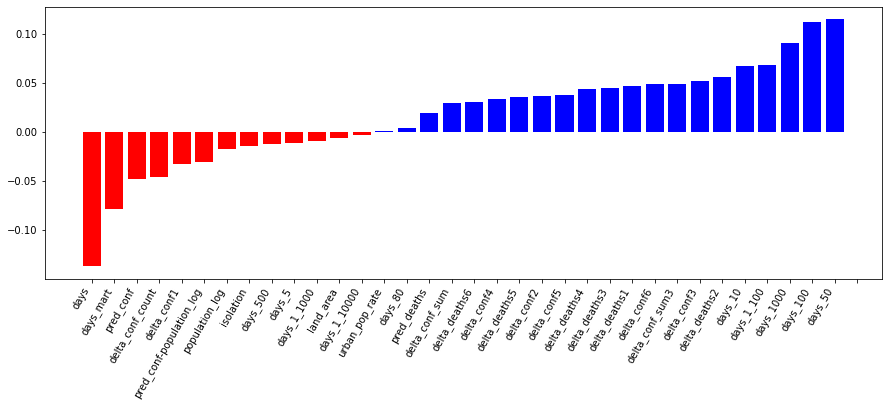

In [783]:
model_Confirmed["Ridge"] = linear_model.Ridge().fit(train_data, train_labels)
model_Death["Ridge"] = linear_model.Ridge().fit(train_data, train_death)
visualize_coefficients(model_Confirmed["Ridge"], train_data.columns)
del model_Confirmed["Ridge"]

### Lasso

In [0]:
#model_Confirmed["Lasso"] = linear_model.Lasso().fit(train_data, train_labels)
#model_Death["Lasso"] = linear_model.Lasso().fit(train_data, train_death)

### SGDRegressor

In [0]:
#model_Confirmed["SGDRegressor"] = linear_model.SGDRegressor().fit(train_data, train_labels)
#model_Death["SGDRegressor"] = linear_model.SGDRegressor().fit(train_data, train_death)

## Нейронная сеть

### Обучаем MLPRegressor

In [786]:
"""
model_Confirmed["MLPRegressor"] = MLPRegressor(hidden_layer_sizes=(100, 100),max_iter=5000,
                                 learning_rate_init=0.01, random_state=0,
                                 early_stopping=True).fit(train_data, train_labels)
                                                            
model_Death["MLPRegressor"] = MLPRegressor(hidden_layer_sizes=(100, 100),max_iter=5000,
                                 learning_rate_init=0.01, random_state=0,
                                 early_stopping=True).fit(train_data, train_death)
"""

'\nmodel_Confirmed["MLPRegressor"] = MLPRegressor(hidden_layer_sizes=(100, 100),max_iter=5000,\n                                 learning_rate_init=0.01, random_state=0,\n                                 early_stopping=True).fit(train_data, train_labels)\n                                                            \nmodel_Death["MLPRegressor"] = MLPRegressor(hidden_layer_sizes=(100, 100),max_iter=5000,\n                                 learning_rate_init=0.01, random_state=0,\n                                 early_stopping=True).fit(train_data, train_death)\n'

### Обучаем Keras

In [787]:
"""def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_data.keys())]),
    keras.layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dropout(0.2),    
    layers.Dense(1)
  ])
  model.compile(loss='mse', optimizer='adam', metrics='mse')
  return model

EPOCHS = 100
model_Confirmed["keras"] = build_model()
history = model_Confirmed["keras"].fit(train_data, train_labels, epochs=EPOCHS, validation_split = 0.1, verbose=0)
model_Death["keras"] = build_model()
history = model_Death["keras"].fit(train_data, train_death, epochs=EPOCHS, validation_split = 0.1, verbose=0)
plt.rcParams['figure.figsize'] = [20, 10]
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$MPG^2$]')
plt.plot(hist['epoch'], hist['mse'], label='Train Error')
plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
plt.legend()
"""

'def build_model():\n  model = keras.Sequential([\n    layers.Dense(128, activation=\'relu\', input_shape=[len(train_data.keys())]),\n    keras.layers.Dropout(0.2),\n    layers.Dense(32, activation=\'relu\', kernel_regularizer=keras.regularizers.l2(0.1)),\n    keras.layers.Dropout(0.2),    \n    layers.Dense(1)\n  ])\n  model.compile(loss=\'mse\', optimizer=\'adam\', metrics=\'mse\')\n  return model\n\nEPOCHS = 100\nmodel_Confirmed["keras"] = build_model()\nhistory = model_Confirmed["keras"].fit(train_data, train_labels, epochs=EPOCHS, validation_split = 0.1, verbose=0)\nmodel_Death["keras"] = build_model()\nhistory = model_Death["keras"].fit(train_data, train_death, epochs=EPOCHS, validation_split = 0.1, verbose=0)\nplt.rcParams[\'figure.figsize\'] = [20, 10]\nhist = pd.DataFrame(history.history)\nhist[\'epoch\'] = history.epoch\nplt.xlabel(\'Epoch\')\nplt.ylabel(\'Mean Square Error [$MPG^2$]\')\nplt.plot(hist[\'epoch\'], hist[\'mse\'], label=\'Train Error\')\nplt.plot(hist[\'epoch\']

### Обучаем Pytorch

In [788]:
"""
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(len(train_data.keys()), 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = F.relu(self.fc2(x))
    x = F.dropout(x, p=0.2)
    x = self.fc3(x)
    return x
  def predict(self, data):
    pred_y = self(data)
    return pred_y.detach().numpy()[:,0]

model_Confirmed["pytorch"] = Net()

X = Variable(torch.tensor(train_data.values)).float()
target = Variable(torch.tensor(train_labels.to_numpy().reshape(-1,1))).float()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_Confirmed["pytorch"].parameters(), lr = 0.005)
epochs = 200
for epoch in range(epochs):
  net_out = model_Confirmed["pytorch"](X)
  loss = criterion(net_out, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if (epoch + 1) % (epochs / 10) == 0:
      print('epoch {}, loss {}'.format(epoch, loss.item()))
model_Confirmed["pytorch"].eval()      

model_Death["pytorch"] =Net()
target = Variable(torch.tensor(train_death.to_numpy().reshape(-1,1))).float()
for epoch in range(epochs):
  net_out = model_Death["pytorch"](X)
  loss = criterion(net_out, target)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
model_Death["pytorch"].eval()
"""

'\nclass Net(nn.Module):\n  def __init__(self):\n    super(Net, self).__init__()\n    self.fc1 = nn.Linear(len(train_data.keys()), 100)\n    self.fc2 = nn.Linear(100, 100)\n    self.fc3 = nn.Linear(100, 1)\n  def forward(self, x):\n    x = F.relu(self.fc1(x))\n    x = F.dropout(x, p=0.2)\n    x = F.relu(self.fc2(x))\n    x = F.dropout(x, p=0.2)\n    x = self.fc3(x)\n    return x\n  def predict(self, data):\n    pred_y = self(data)\n    return pred_y.detach().numpy()[:,0]\n\nmodel_Confirmed["pytorch"] = Net()\n\nX = Variable(torch.tensor(train_data.values)).float()\ntarget = Variable(torch.tensor(train_labels.to_numpy().reshape(-1,1))).float()\n\ncriterion = torch.nn.MSELoss()\noptimizer = torch.optim.Adam(model_Confirmed["pytorch"].parameters(), lr = 0.005)\nepochs = 200\nfor epoch in range(epochs):\n  net_out = model_Confirmed["pytorch"](X)\n  loss = criterion(net_out, target)\n  optimizer.zero_grad()\n  loss.backward()\n  optimizer.step()\n  if (epoch + 1) % (epochs / 10) == 0:\n    

## Бустинг и Лес

### Обучаем случайный лес

In [789]:
"""
param_grid = {
    'n_estimators': [200], #Больше - лучше
    'max_depth':[5, 10, 15]
                }
RandomForest1 = ensemble.RandomForestRegressor(random_state=42)
model_Confirmed["RandomForest"] = model_selection.GridSearchCV(estimator = RandomForest1, param_grid = param_grid, 
                                         cv = 3, n_jobs = -1).fit(train_data, train_labels)
model_Death["RandomForest"] = model_selection.GridSearchCV(estimator = RandomForest1, param_grid = param_grid, 
                                         cv = 3, n_jobs = -1).fit(train_data, train_labels)
model_Confirmed["RandomForest"].best_params_
"""

'\nparam_grid = {\n    \'n_estimators\': [200], #Больше - лучше\n    \'max_depth\':[5, 10, 15]\n                }\nRandomForest1 = ensemble.RandomForestRegressor(random_state=42)\nmodel_Confirmed["RandomForest"] = model_selection.GridSearchCV(estimator = RandomForest1, param_grid = param_grid, \n                                         cv = 3, n_jobs = -1).fit(train_data, train_labels)\nmodel_Death["RandomForest"] = model_selection.GridSearchCV(estimator = RandomForest1, param_grid = param_grid, \n                                         cv = 3, n_jobs = -1).fit(train_data, train_labels)\nmodel_Confirmed["RandomForest"].best_params_\n'

### Обучаем xgboost

In [790]:
"""model_Confirmed["Xgboost"] = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=iterat, max_depth=13, 
                                              n_jobs = -1).fit(train_data, train_labels)
model_Death["Xgboost"] = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=iterat//10, max_depth=13, 
                                          n_jobs = -1).fit(train_data, train_death)"""

'model_Confirmed["Xgboost"] = xgb.XGBRegressor(objective =\'reg:squarederror\',n_estimators=iterat, max_depth=13, \n                                              n_jobs = -1).fit(train_data, train_labels)\nmodel_Death["Xgboost"] = xgb.XGBRegressor(objective =\'reg:squarederror\',n_estimators=iterat//10, max_depth=13, \n                                          n_jobs = -1).fit(train_data, train_death)'

### Обучаем Adaboost Regressor

In [791]:
"""treeDepth = 30
mdl = tree.DecisionTreeRegressor(max_depth=treeDepth)
param_grid = {
    'n_estimators': [iterat//10],
    'learning_rate': [0.0001],
    'loss' : ["exponential"]
                }
regrMdl = ensemble.AdaBoostRegressor(base_estimator=mdl)
model_Confirmed["Adaboost"] = model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 2, n_jobs = -1).fit(train_data, train_labels)
model_Death["Adaboost"] = model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, 
                                         cv = 2, n_jobs = -1).fit(train_data, train_death)
model_Confirmed["Adaboost"].best_params_"""

'treeDepth = 30\nmdl = tree.DecisionTreeRegressor(max_depth=treeDepth)\nparam_grid = {\n    \'n_estimators\': [iterat//10],\n    \'learning_rate\': [0.0001],\n    \'loss\' : ["exponential"]\n                }\nregrMdl = ensemble.AdaBoostRegressor(base_estimator=mdl)\nmodel_Confirmed["Adaboost"] = model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, \n                                         cv = 2, n_jobs = -1).fit(train_data, train_labels)\nmodel_Death["Adaboost"] = model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, \n                                         cv = 2, n_jobs = -1).fit(train_data, train_death)\nmodel_Confirmed["Adaboost"].best_params_'

### Catboost

In [0]:
model_Confirmed["catboost"] = CatBoostRegressor(iterations=iterat*5, depth=10,  l2_leaf_reg = 1, verbose=False).fit(train_data, train_labels) 
model_Death["catboost"] = CatBoostRegressor(iterations=iterat, depth=10, verbose=False).fit(train_data, train_death)
#print(model_Confirmed["catboost"].get_all_params())

### Lightgbm

In [0]:
params = {'min_data': 10}
d_train = lgb.Dataset(train_data, label=train_labels)
model_Confirmed["lightgbm"]  = lgb.train(params, d_train, iterat)
d_train = lgb.Dataset(train_data, label=train_death)
model_Death["lightgbm"]  = lgb.train(params, d_train, iterat)

## Обучаем свою модель

In [0]:
#model_Confirmed["new"] = 
#model_Death["new"] = 

#Предсказываем новые данные

## Функция отображения данных

In [0]:
def plot_new(list_countries, Matrix, Death = False,subplot_x = 2, days_before = 10, point = True):
  dat2 = data2.copy()
  plt.rcParams['figure.figsize'] = [20, len(list_countries)*20/subplot_x**2]
  if log_labels:
    dat2.deaths = 10**dat2.deaths - 1
    dat2.confirmed = 10**dat2.confirmed - 1
  else:
    dat2.deaths = 10**3*dat2.deaths
    dat2.confirmed = 10**4*dat2.confirmed  
  for i, Country in enumerate(list_countries):
    plt.subplot(len(list_countries)// subplot_x + 1, subplot_x, i+1)
    yyy = dat2.loc[(dat2.iso_alpha3 == Country)&(dat2.confirmed>0)&(dat2.days_mart>=(days_x - days_before)/sc_days)]
    if Death:
      if point:
        plt.plot(yyy.date, yyy.deaths, label = "Истинное значение", marker='o')
        ax = plt.gca()
        for x,y,i in zip(yyy.date,yyy.deaths,range(0,len(yyy))):
          if not i % ((subplot_x * (days_before+days_prog))//20):
            plt.annotate(int(y), (x,y), textcoords="offset points", xytext=(-5,10), ha="right", va = "bottom")
      plt.plot(yyy.date, yyy.deaths, label = "Истинное значение")
      plt.gca().set(xlabel='Дата', ylabel='Смерти')
    else:
      if point:
        plt.plot(yyy.date, yyy.confirmed, label = "Истинное значение", marker='o')
        ax = plt.gca()
        for x,y,i in zip(yyy.date,yyy.confirmed,range(0,len(yyy))):
          if not i % ((subplot_x * (days_before+days_prog))//20):
            plt.annotate(int(y), (x,y), textcoords="offset points", xytext=(-5,10), ha="right", va = "bottom")
      else:
        plt.plot(yyy.date, yyy.confirmed, label = "Истинное значение")
      plt.gca().set(xlabel='Дата', ylabel='Заражения')
    for name in Matrix:
      yyy2 = Matrix[name].loc[:,[Country]]
      if point:
        plt.plot(yyy2, label = name, marker='o')
        ax = plt.gca()
        for x,y,i in zip(yyy2.index,yyy2.values.T[0],range(0,len(yyy2))):
          if not i % ((subplot_x * (days_before+days_prog))//20):
            plt.annotate(int(y), (x,y), textcoords="offset points", xytext=(5,-10), ha="left", va = "top")
      else:
        plt.plot(yyy2, label = name)
    plt.title(dic_countries[Country])
    plt.xticks(np.arange(0, (days_before+days_prog), ((days_before+days_prog)//10)*subplot_x))
    #plt.yticks(np.linspace(0,10+days_prog,30//subplot_x))
    plt.grid(True)
    plt.legend()

#Считаем скор
def pred_score(predictions, day):
  yyy = new_data[(new_data.days_mart==(days_x + day - 1)/sc_days) & (new_data.confirmed > 0)]
  region_list_x = new_data[(new_data.days_mart==(days_x)/sc_days) & (new_data.confirmed > 0)].countries.to_list()
  yyy = yyy[yyy.countries.isin(region_list_x)]
  #print(len(yyy),len(predictions))
  
  if len(yyy)==len(predictions):

    labels = yyy.confirmed.values  
    if log_labels:
      labels = 10**labels - 1
    else:
      labels = 10**4*labels
    return np.mean(np.abs(np.log10((predictions+1)/(labels+1))))
  else:
    return 0      

## Расчёт значений

In [0]:
#del model_Confirmed["Adaboost"]

In [861]:
# Сколько дней прогнозируем?
days_prog = 14   #256
podgon = True


Matrix_confirmed,Matrix_Death ={},{}
data_list = pd.date_range('2020-04-'+str(days_x-31), periods = days_prog+1, freq ='d')
data_list = data_list.strftime('%#m-%#d') 
new_data_list = data_x.copy()
labels = new_data_list.iso_alpha3
Matrix_confirmed["Среднее"] = pd.DataFrame(np.zeros((days_prog+1, len(labels))),columns = labels,index = data_list)
Matrix_Death["Среднее"] = pd.DataFrame(np.zeros((days_prog+1, len(labels))),columns = labels,index = data_list)

for model_name in model_Confirmed:
  scores = []
  new_data_list = data_x.copy()
  labels = new_data_list.iso_alpha3
  if log_labels:
    predictions_confirmed = [(10**new_data_list.pred_conf - 1).tolist()]
    predictions_Death = [(10**new_data_list.pred_deaths - 1).tolist()]
  else:
    predictions_confirmed = [(new_data_list.pred_conf*10**4).tolist()]
    predictions_Death = [(new_data_list.pred_deaths*10**3).tolist()]        
  new_data_list = new_data_list.drop(['iso_alpha3','region','confirmed','countries','deaths',"delta_conf","delta_deaths"], axis='columns')  
  for i in range(days_prog):
    #print(data.iloc[-10:-7,-5:])
    if model_name == "pytorch":
      prediction_confirmed = model_Confirmed[model_name].predict(torch.tensor(new_data_list.values).float())
      prediction_Death = model_Death[model_name].predict(torch.tensor(new_data_list.values).float())
    else:
      prediction_confirmed = model_Confirmed[model_name].predict(new_data_list).flatten()
      prediction_Death = model_Death[model_name].predict(new_data_list).flatten()
    prediction_confirmed[prediction_confirmed<0] = 0
    prediction_Death[prediction_Death<0] = 0
    #prediction_confirmed = prediction_confirmed + new_data_list.delta_conf_sum
    #prediction_confirmed = prediction_confirmed + new_data_list.delta_conf1   
    if podgon:
      prediction_confirmed = prediction_confirmed*(0.95**(new_data_list.days_5.values*5))
      prediction_Death = prediction_Death*(0.95**(new_data_list.days_5.values*5))
    
    if type_ans_delta:
      if log_labels:
        prediction_confirmed = prediction_confirmed + new_data_list.pred_conf.values
        prediction_Death = prediction_Death + new_data_list.pred_deaths.values
      else:
        #prediction_confirmed = prediction_confirmed + new_data_list.pred_conf.values
        #prediction_Death = prediction_Death + new_data_list.pred_deaths.values        
        prediction_Death = (1+prediction_Death)*(new_data_list.pred_deaths.values  + 0.001) 
        prediction_confirmed = (1+prediction_confirmed)*(new_data_list.pred_conf.values  + 0.0001)


    if ('delta_conf_sum' in new_data_list.columns):
      new_data_list["delta_conf_sum"] = 0
    if ('delta_conf6' in new_data_list.columns):
      new_data_list["delta_conf6"] = new_data_list["delta_conf5"]
      if ('delta_conf_sum' in new_data_list.columns):
        new_data_list["delta_conf_sum"] = new_data_list["delta_conf_sum"] + new_data_list["delta_conf6"]
    if ('delta_conf5' in new_data_list.columns):
      new_data_list["delta_conf5"] = new_data_list["delta_conf4"]
      if ('delta_conf_sum' in new_data_list.columns):
        new_data_list["delta_conf_sum"] = new_data_list["delta_conf_sum"] + new_data_list["delta_conf5"]
    if ('delta_conf4' in new_data_list.columns):
      new_data_list["delta_conf4"] = new_data_list["delta_conf3"]    
      if ('delta_conf_sum' in new_data_list.columns):
        new_data_list["delta_conf_sum"] = new_data_list["delta_conf_sum"] + new_data_list["delta_conf4"]
    if ('delta_conf3' in new_data_list.columns):
      new_data_list["delta_conf3"] = new_data_list["delta_conf2"]
      if ('delta_conf_sum' in new_data_list.columns):
        new_data_list["delta_conf_sum"] = new_data_list["delta_conf_sum"] + new_data_list["delta_conf3"]
      if ('delta_conf_sum3' in new_data_list.columns):
        new_data_list["delta_conf_sum3"] = new_data_list["delta_conf_sum3"] + new_data_list["delta_conf3"]        
    if ('delta_conf2' in new_data_list.columns):
      new_data_list["delta_conf2"] = new_data_list["delta_conf1"]
      if ('delta_conf_sum' in new_data_list.columns):
        new_data_list["delta_conf_sum"] = new_data_list["delta_conf_sum"] + new_data_list["delta_conf2"]
      if ('delta_conf_sum3' in new_data_list.columns):
        new_data_list["delta_conf_sum3"] = new_data_list["delta_conf_sum3"] + new_data_list["delta_conf2"]        
    new_data_list["delta_conf1"] = (prediction_confirmed - new_data_list["pred_conf"])
        
    if ('delta_conf_sum' in new_data_list.columns):
      new_data_list["delta_conf_sum"] = new_data_list["delta_conf_sum"] + new_data_list["delta_conf1"]
      new_data_list["delta_conf_sum"] = new_data_list["delta_conf_sum"]/6
    if ('delta_conf_sum3' in new_data_list.columns):
      new_data_list["delta_conf_sum3"] = new_data_list["delta_conf_sum3"] + new_data_list["delta_conf1"]
      new_data_list["delta_conf_sum3"] = new_data_list["delta_conf_sum3"]/3


    if ('delta_conf_count' in new_data_list.columns) and ('delta_conf1' in new_data_list.columns) and ('delta_conf2' in new_data_list.columns):
      new_data_list.loc[(new_data_list["delta_conf1"] < new_data_list["delta_conf2"]) | 
                        ((new_data_list["delta_conf1"] <0.02) & (new_data_list["delta_conf1"]>0)),"delta_conf_count"] +=0.2
    if ('delta_conf_count' in new_data_list.columns) and ('delta_conf2' in new_data_list.columns) and ('delta_conf3' in new_data_list.columns):
      new_data_list.loc[(new_data_list["delta_conf2"] < new_data_list["delta_conf3"]) | 
                      ((new_data_list["delta_conf2"] <0.02) & (new_data_list["delta_conf2"]>0)),"delta_conf_count"] +=0.2
    if ('delta_conf_count' in new_data_list.columns) and ('delta_conf3' in new_data_list.columns) and ('delta_conf4' in new_data_list.columns):
      new_data_list.loc[(new_data_list["delta_conf3"] < new_data_list["delta_conf4"]) | 
                      ((new_data_list["delta_conf3"] <0.02) & (new_data_list["delta_conf3"]>0)),"delta_conf_count"] +=0.2
    if ('delta_conf_count' in new_data_list.columns) and ('delta_conf4' in new_data_list.columns) and ('delta_conf5' in new_data_list.columns):
      new_data_list.loc[(new_data_list["delta_conf4"] < new_data_list["delta_conf5"]) | 
                      ((new_data_list["delta_conf4"] <0.02) & (new_data_list["delta_conf4"]>0)),"delta_conf_count"] +=0.2
    if ('delta_conf_count' in new_data_list.columns) and ('delta_conf5' in new_data_list.columns) and ('delta_conf6' in new_data_list.columns):
      new_data_list.loc[(new_data_list["delta_conf5"] < new_data_list["delta_conf6"]) | 
                      ((new_data_list["delta_conf5"] <0.02) & (new_data_list["delta_conf5"]>0)),"delta_conf_count"] +=0.2    

    if ('delta_deaths6' in new_data_list.columns):
      new_data_list["delta_deaths6"] = new_data_list["delta_deaths5"]
    if ('delta_deaths5' in new_data_list.columns):
      new_data_list["delta_deaths5"] = new_data_list["delta_deaths4"]
    if ('delta_deaths4' in new_data_list.columns):
      new_data_list["delta_deaths4"] = new_data_list["delta_deaths3"]
    if ('delta_deaths3' in new_data_list.columns):
      new_data_list["delta_deaths3"] = new_data_list["delta_deaths2"]
    if ('delta_deaths2' in new_data_list.columns):
      new_data_list["delta_deaths2"] = new_data_list["delta_deaths1"]
    new_data_list["delta_deaths1"] = prediction_Death - new_data_list["pred_deaths"] 
    
    if ('days_mart' in new_data_list.columns):  
      new_data_list["days_mart"] += 1/sc_days
    if ('days' in new_data_list.columns):
      new_data_list["days"] += 1/sc_days
    if ('days_after_Quarantine' in new_data_list.columns):
      new_data_list['days_after_Quarantine'] += 1/sc_days


    if ('days_10' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_10']>-100,'days_10'] += 1/sc_days      
    if ('days_100' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_100']>-100,'days_100'] += 1/sc_days
    if ('days_1000' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_1000']>-100,'days_1000'] += 1/sc_days
    if ('days_5' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_5']>-100,'days_5'] += 1/sc_days      
    if ('days_50' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_50']>-100,'days_50'] += 1/sc_days
    if ('days_500' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_500']>-100,'days_500'] += 1/sc_days
    if ('days_8' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_8']>-100,'days_8'] += 1/sc_days      
    if ('days_80' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_80']>-100,'days_80'] += 1/sc_days      
    if ('days_1_100' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_1_100']>-100,'days_1_100'] += 1/sc_days
    if ('days_1_1000' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_1_1000']>-100,'days_1_1000'] += 1/sc_days
    if ('days_1_10000' in new_data_list.columns):
      new_data_list.loc[new_data_list['days_1_10000']>-100,'days_1_10000'] += 1/sc_days
    if ('recovered' in new_data_list.columns) and ('pred_recovered' in new_data_list.columns):
      new_data_list["recovered"] = new_data_list["recovered"] - new_data_list["pred_recovered"] + new_data_list["recovered"]*0.95
    new_data_list["pred_deaths"] = prediction_Death
    new_data_list["pred_conf"] = prediction_confirmed    

    if log_labels:
      prediction_Death = 10**prediction_Death - 1
      prediction_confirmed = 10**prediction_confirmed - 1    
    else:
      prediction_Death = 10**3*prediction_Death 
      prediction_confirmed = 10**4*prediction_confirmed
    
    if ('pred_conf-population_log' in new_data_list.columns and 'population_log' in new_data_list.columns):
      new_data_list['pred_conf-population_log'] = new_data_list['pred_conf'] - new_data_list['population_log'] + 3      
      if ('days_1_100' in new_data_list.columns):
        new_data_list.loc[(new_data_list['pred_conf-population_log'] > -1)&(new_data_list['days_1_100']<1), 'days_1_100'] = 1/sc_days
      if ('days_1_1000' in new_data_list.columns):
        new_data_list.loc[(new_data_list['pred_conf-population_log'] > 0)&(new_data_list['days_1_1000']<1), 'days_1_1000'] = 1/sc_days
      if ('days_1_10000' in new_data_list.columns):
        new_data_list.loc[(new_data_list['pred_conf-population_log'] > -2)&(new_data_list['days_1_10000']<1), 'days_1_10000'] = 1/sc_days

    prediction_confirmed[prediction_confirmed>10**7] = 10**7
    prediction_Death[prediction_Death>10**6] = 10**6      
    predictions_Death.append(np.round(prediction_Death))
    predictions_confirmed.append(np.round(prediction_confirmed))

    score = pred_score(prediction_confirmed,i+1)
    if score:
      scores.append(score)
    if ('days_10' in new_data_list.columns):
      new_data_list.loc[(new_data_list.days_10<1) & (prediction_confirmed > 10),"days_10"] = 1
    if ('days_100' in new_data_list.columns):
      new_data_list.loc[(new_data_list.days_100<1) & (prediction_confirmed > 100),"days_100"] = 1
    if ('days_1000' in new_data_list.columns):
      new_data_list.loc[(new_data_list.days_1000<1) & (prediction_confirmed > 1000),"days_1000"] = 1
    if ('days_5' in new_data_list.columns):
      new_data_list.loc[(new_data_list.days_5<1) & (prediction_confirmed > 5),"days_5"] = 1
    if ('days_50' in new_data_list.columns):
      new_data_list.loc[(new_data_list.days_50<1) & (prediction_confirmed > 50),"days_50"] = 1
    if ('days_500' in new_data_list.columns):
      new_data_list.loc[(new_data_list.days_500<1) & (prediction_confirmed > 500),"days_500"] = 1
    if ('days_8' in new_data_list.columns):
      new_data_list.loc[(new_data_list.days_8<1) & (prediction_confirmed > 8),"days_8"] = 1
    if ('days_80' in new_data_list.columns):
      new_data_list.loc[(new_data_list.days_80<1) & (prediction_confirmed > 80),"days_80"] = 1
  Matrix_confirmed[model_name] = pd.DataFrame(predictions_confirmed,columns = labels,index = data_list)
  Matrix_Death[model_name] = pd.DataFrame(predictions_Death,columns = labels,index = data_list)
  Matrix_confirmed["Среднее"] += Matrix_confirmed[model_name]
  Matrix_Death["Среднее"] += Matrix_Death[model_name]
  print(model_name, sum(scores), scores)
Matrix_confirmed["Среднее"] = Matrix_confirmed["Среднее"]//len(model_Confirmed)
Matrix_Death["Среднее"] = Matrix_Death["Среднее"]//len(model_Confirmed)
scores = []
for i,(index, row) in enumerate(Matrix_confirmed["Среднее"].iterrows()):
  score = pred_score(np.abs(row),i)
  if score:
    scores.append(score)
print("Среднее", sum(scores), scores)  

catboost 0.23261253226930223 [0.0030116278131958807, 0.018250718928713498, 0.02652701820125952, 0.03317915110075785, 0.042178783273179615, 0.04941011069809456, 0.06005512225410131]
lightgbm 0.2418131813267396 [0.00491147794771029, 0.018457892344761712, 0.026933955856694277, 0.03341518308722369, 0.04371224591330149, 0.05172482342171431, 0.06265760275533386]
Среднее 0.22953590476126384 [0.0036546409662471455, 0.017773606082787014, 0.025486106937529635, 0.032087679648478515, 0.04160871117475131, 0.04887843688762621, 0.060046723063844]


## Строим график

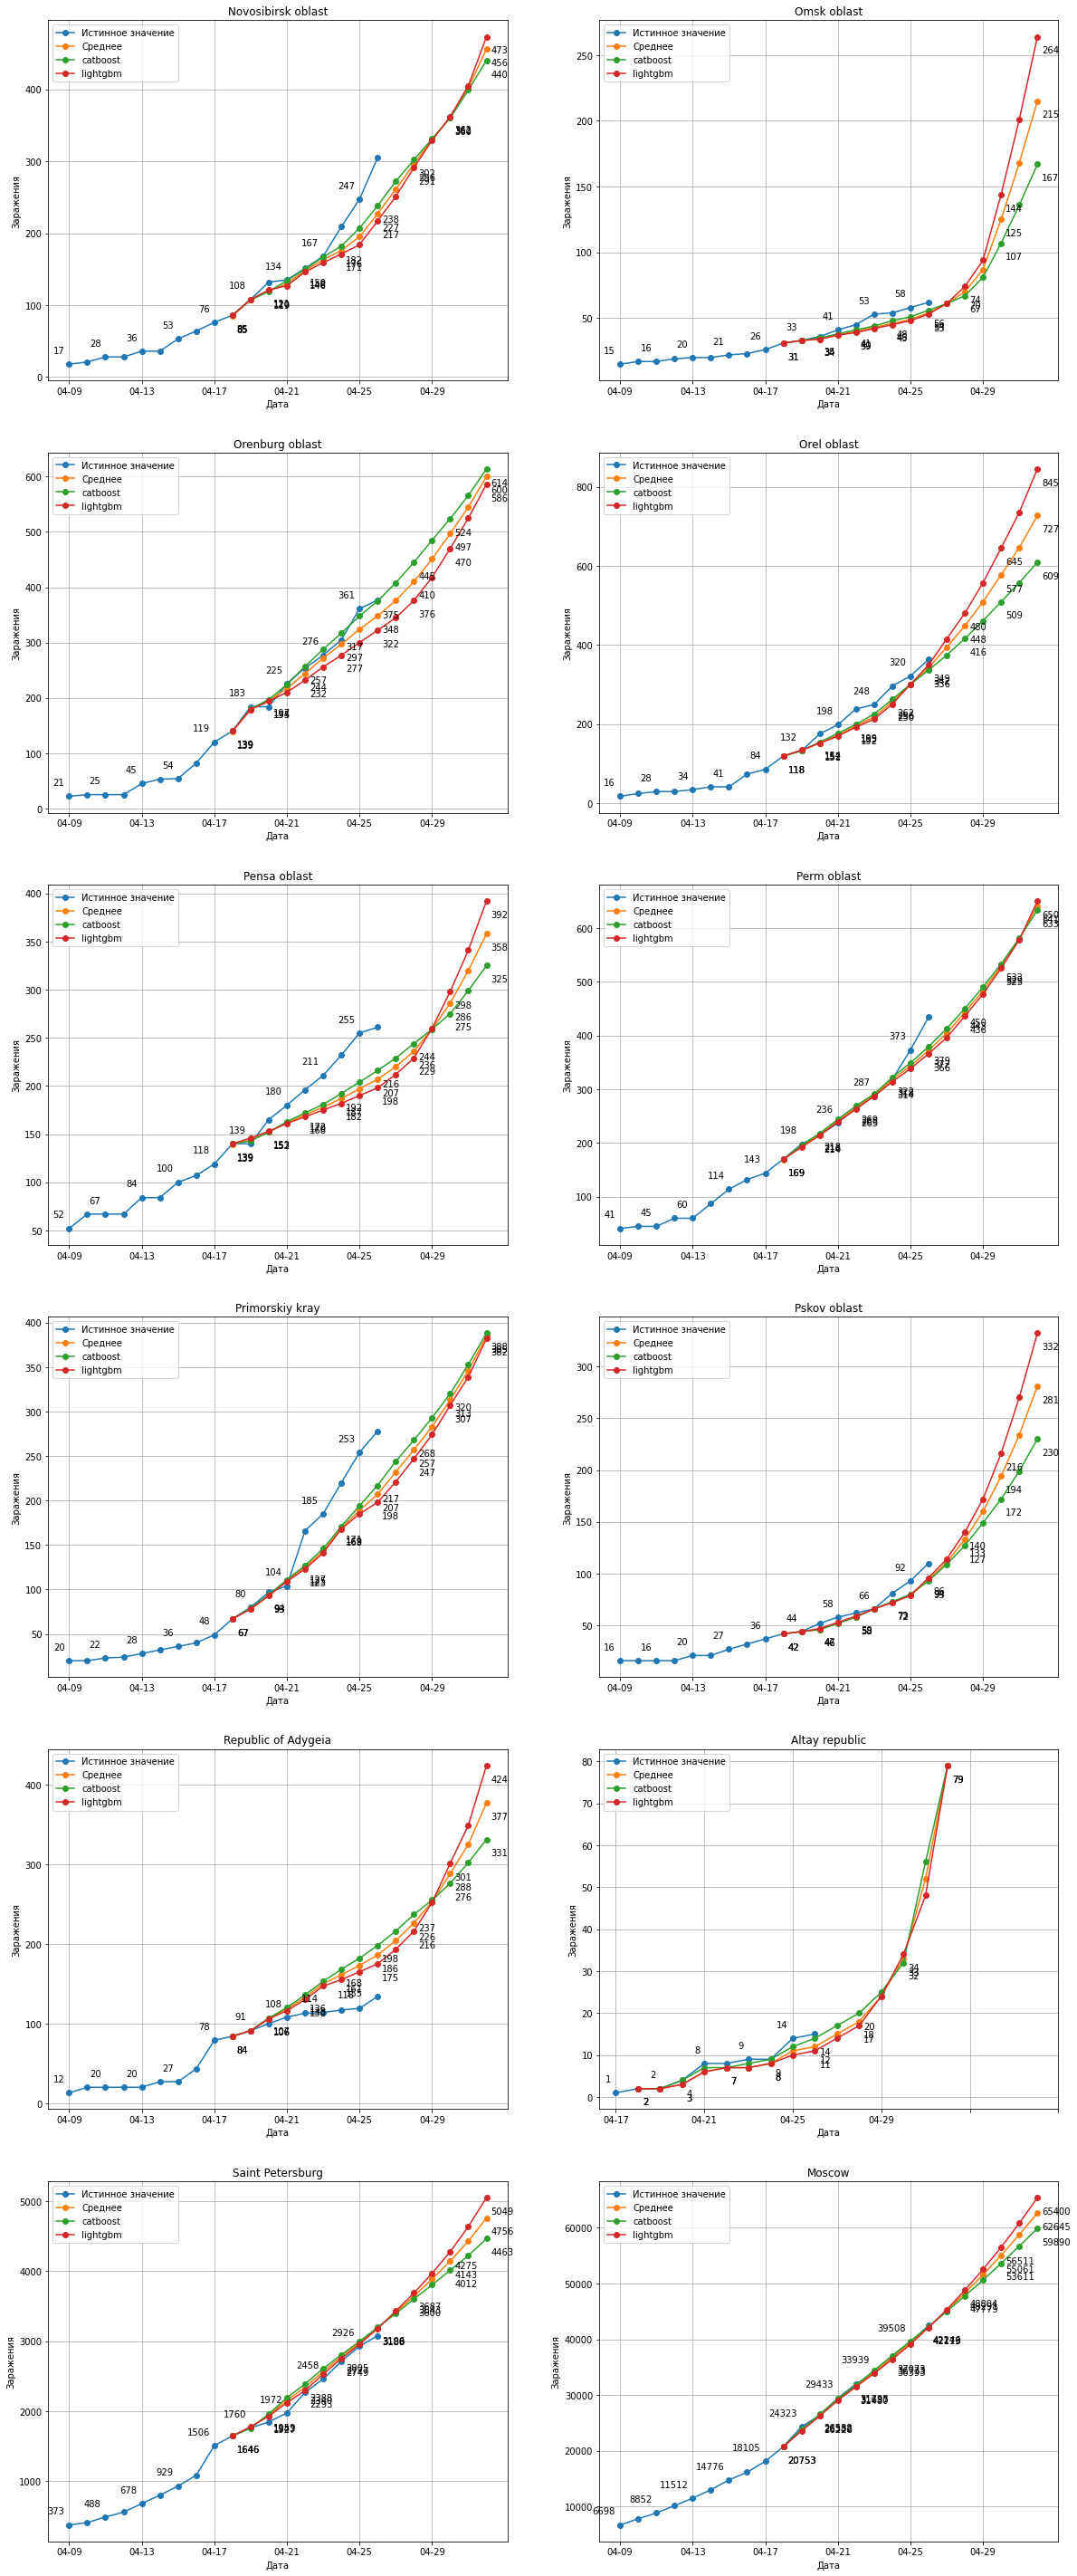

In [874]:
# Создаём список стран
list_countries = countries.iso_alpha3.to_list()[-100:-90]
#list_countries = []
list_countries.extend(["RU-SPE","RU-MOW"])
#list_countries.extend(["RUS","FRA","ITA","CHN","KOR","USA"])
# Количество графиков в строке
subplot_x = 2
# Отмечать точки
point = True

#За сколько дней до начала прогноза
days_before = 10

#Строим для заражений, или смертей
death_bool = False 
if death_bool:
  Matrix = Matrix_Death
else:
  Matrix = Matrix_confirmed
#Matrix = {"Предсказанное": Matrix["Adaboost"]}
plot_new(list_countries, Matrix, death_bool, subplot_x, days_before, point)

In [863]:
Matrix_confirmed.keys()

dict_keys(['Среднее', 'catboost', 'lightgbm'])

# Сохраняем прогноз

In [0]:
ans = Matrix_confirmed["Среднее"].stack().reset_index()
ans_Death = Matrix_Death["Среднее"].stack().reset_index()
ans["prediction_deaths"] = ans_Death[0]
ans.columns = ['date','region','prediction_confirmed', 'prediction_deaths']
ans['date'] = pd.to_datetime('2020-'+ans['date'])
ans['prediction_confirmed'] = ans['prediction_confirmed'].astype('int')
ans['prediction_deaths'] = ans['prediction_deaths'].astype('int')
ans.sort_values(by=['region', 'date']).to_csv('submission.csv', index=False)

# Считаю ОШИБКУ

In [866]:
"""ers = 0
submission = pd.read_csv("/content/submission.csv")
data222 = data2[['date','iso_alpha3','confirmed']]
data222.confirmed = 10**data222.confirmed - 1
data222.date = "2020-" + data222.date
submission = submission.merge(data222, how = 'left', left_on=('date','region'), right_on=('date','iso_alpha3'))
submission = submission[submission.confirmed>0]
submission = submission.loc[submission.region.str.contains('-')]
for i in ['2020-04-20','2020-04-21','2020-04-22','2020-04-23','2020-04-24','2020-04-25','2020-04-26']:
  sub = submission[submission.date == i]
  er = np.mean(np.abs(np.log10((sub.confirmed.values+1)/(sub.prediction_confirmed.values+1))))
  ers += er
  print(i, er)
print("Общая", ers)"""

'ers = 0\nsubmission = pd.read_csv("/content/submission.csv")\ndata222 = data2[[\'date\',\'iso_alpha3\',\'confirmed\']]\ndata222.confirmed = 10**data222.confirmed - 1\ndata222.date = "2020-" + data222.date\nsubmission = submission.merge(data222, how = \'left\', left_on=(\'date\',\'region\'), right_on=(\'date\',\'iso_alpha3\'))\nsubmission = submission[submission.confirmed>0]\nsubmission = submission.loc[submission.region.str.contains(\'-\')]\nfor i in [\'2020-04-20\',\'2020-04-21\',\'2020-04-22\',\'2020-04-23\',\'2020-04-24\',\'2020-04-25\',\'2020-04-26\']:\n  sub = submission[submission.date == i]\n  er = np.mean(np.abs(np.log10((sub.confirmed.values+1)/(sub.prediction_confirmed.values+1))))\n  ers += er\n  print(i, er)\nprint("Общая", ers)'

# Мусор удалить. Считаем ошибку MALE и строим графики

In [0]:
param_list =['countries', 'confirmed', 'deaths', 'iso_alpha3', 'delta_conf', 'delta_deaths', 'region',
              'pred_conf', 'pred_deaths', 'delta_conf1', 'delta_deaths1',
             "delta_conf_count",
              "isolation",
             'testpop',
             'Health_GDP',
             'Physicians', 
             'urban_pop_rate',             
             'hospibed',
             'Nurse',
              'pred_conf-population_log',              
             'population_log',
             'tests',
             'population',
             'gatheringlimit',
             'world_share',
             'fertility_rate', 
             'migrants', 
             'land_area',
             'healthperpop',
             'Age_old/new', 
             'Health_USD', 
             'median_age',             
             'Smoking', 
             'density',
             'pred_recovered',
             'recovered',
             'days',
             'days_10',
             'days_100',
             'days_1000',
             'days_1_1000',
             'days_after_Quarantine', 
             'delta_conf2', 
             'delta_deaths2',
             'delta_conf3', 
             'delta_deaths3',
             'delta_conf4', 
             'delta_deaths4',
             'delta_conf5', 
             'delta_deaths5',
             'delta_conf6', 
             'delta_deaths6',
             "delta_conf_sum",
             'days_mart']

## Функция

In [868]:
"""
def pred_score(models, data, death = False, plot = 0):
  predictions_all = 0
  plt.rcParams['figure.figsize'] = [20, len(models)*10]
  #data = data[(data.days_mart < 43/sc_days)] # исправить
  data = data[data.confirmed > 0]
  if not len(data):
    return False

  if log_labels:
    death_labels = 10**data.deaths - 1
    labels = 10**data.confirmed - 1
  else:
    death_labels = 10**3 * data.deaths
    labels = 10**4 * data.confirmed   
  data = data.drop([ 'iso_alpha3','confirmed','countries','deaths',"delta_conf","delta_deaths"], axis='columns')  
  
  for i, model in enumerate(models):
    if model == "pytorch":
      predictions = models[model].predict(torch.tensor(data.values).float())
    else:
      predictions = models[model].predict(data).flatten()
    
    if type_ans_delta:
      if log_labels:
        if death:
          predictions = predictions + data.pred_deaths.values
        else:
          predictions = predictions + data.pred_conf.values
      else:
        if death:
          predictions = (1+predictions)*(data.pred_deaths.values + 0.001)
        else:
          predictions = (1+predictions)*(data.pred_conf.values  + 0.0001)            
    if log_labels:
      predictions = 10**predictions - 1
    else:
      if death:
        predictions = 10**3*predictions
      else:
        predictions = 10**4*predictions
    predictions_all = predictions_all + predictions 
    #print(death_labels)
    #print(predictions)
    
    if death:
      MALE = "Ошибка MALE по смертям " + model + " " + str(np.mean(np.abs(np.log10((predictions+1)/(death_labels+1)))))
    else:
      MALE = "Ошибка MALE по заражениям " + model + " " +  str(np.mean(np.abs(np.log10((predictions+1)/(labels+1)))))
    print(MALE)
    if plot:
      plt.subplot(len(models), 1, i+1)
      if plot==1:
        plt.plot(predictions, label = "Предсказанное значение") 
        if death:
          plt.plot(death_labels.values, label = "Истинное значение")
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Смерти')
        else:
          plt.plot(labels.values, label = "Истинное значение")  
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Заражения')
      if plot==2:
        plt.scatter(np.arange(0,len(predictions),1), predictions, s = 1, label = "Предсказанное значение") 
        if death:
          plt.scatter(np.arange(0,len(predictions),1), death_labels.values, s = 1,  label = "Истинное значение")
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Смерти')
        else:
          plt.scatter(np.arange(0,len(predictions),1), labels.values, s = 1,  label = "Истинное значение")  
          plt.gca().set(xlabel='Дни от случая первого заражения', ylabel='Заражения')      
      plt.title(MALE)
      plt.grid(True)
      plt.legend() 
  predictions_all = predictions_all/len(models)
  if death:
    print("Ошибка MALE по смертям средняя", np.mean(np.abs(np.log10((predictions_all+1)/(death_labels+1)))))
  else:
    print("Ошибка MALE по заражениям средняя", np.mean(np.abs(np.log10((predictions_all+1)/(labels+1)))))   
"""       

'\ndef pred_score(models, data, death = False, plot = 0):\n  predictions_all = 0\n  plt.rcParams[\'figure.figsize\'] = [20, len(models)*10]\n  #data = data[(data.days_mart < 43/sc_days)] # исправить\n  data = data[data.confirmed > 0]\n  if not len(data):\n    return False\n\n  if log_labels:\n    death_labels = 10**data.deaths - 1\n    labels = 10**data.confirmed - 1\n  else:\n    death_labels = 10**3 * data.deaths\n    labels = 10**4 * data.confirmed   \n  data = data.drop([ \'iso_alpha3\',\'confirmed\',\'countries\',\'deaths\',"delta_conf","delta_deaths"], axis=\'columns\')  \n  \n  for i, model in enumerate(models):\n    if model == "pytorch":\n      predictions = models[model].predict(torch.tensor(data.values).float())\n    else:\n      predictions = models[model].predict(data).flatten()\n    \n    if type_ans_delta:\n      if log_labels:\n        if death:\n          predictions = predictions + data.pred_deaths.values\n        else:\n          predictions = predictions + data.pred

## График + Ошибка MALE

In [869]:
"""
# Данные new_data - новые с дня Х, 
# data_Russia - Данные по России
# data_Korea  - Данные по Франции
data_pred = new_data 

# Тип графика 
# 0 - без графика
# 1 - plot
# 2 - scatter
plot_type = 0

#Строим для заражений, или смертей 0.00316
death_bool = False
if death_bool:
  model = model_Death
else:
  model = model_Confirmed

pred_score(model, data_pred, death_bool, plot_type)
"""

'\n# Данные new_data - новые с дня Х, \n# data_Russia - Данные по России\n# data_Korea  - Данные по Франции\ndata_pred = new_data \n\n# Тип графика \n# 0 - без графика\n# 1 - plot\n# 2 - scatter\nplot_type = 0\n\n#Строим для заражений, или смертей 0.00316\ndeath_bool = False\nif death_bool:\n  model = model_Death\nelse:\n  model = model_Confirmed\n\npred_score(model, data_pred, death_bool, plot_type)\n'

In [870]:
"""
#индекс самоизоляции
import requests
import pandas as pd

URL = "https://yastat.net/s3/milab/2020/podomam/data/index_data.json"
data = requests.get(URL).json()

df = pd.DataFrame([[v['date'], city, v['value']] for city, values in data.items() for v in values])
df.columns = ['date', 'city', 'value']
df.city.unique()"""

'\n#индекс самоизоляции\nimport requests\nimport pandas as pd\n\nURL = "https://yastat.net/s3/milab/2020/podomam/data/index_data.json"\ndata = requests.get(URL).json()\n\ndf = pd.DataFrame([[v[\'date\'], city, v[\'value\']] for city, values in data.items() for v in values])\ndf.columns = [\'date\', \'city\', \'value\']\ndf.city.unique()'

## TEST

In [871]:
"""def pred_score2(model, data):
  data = data[data.confirmed > 0]
  death_labels  = data.deaths
  labels = data.confirmed
  death_labels = 10**death_labels - 1
  labels = 10**labels - 1
  data = data.drop([ 'iso_alpha3','confirmed','countries','deaths',"delta_conf","delta_deaths"], axis='columns')  
  predictions = model.predict(data) + data.pred_conf.values
  predictions = 10**predictions - 1        
  MALE = np.sum(np.abs(np.log10((predictions+1)/(labels+1))))
  return MALE"""

'def pred_score2(model, data):\n  data = data[data.confirmed > 0]\n  death_labels  = data.deaths\n  labels = data.confirmed\n  death_labels = 10**death_labels - 1\n  labels = 10**labels - 1\n  data = data.drop([ \'iso_alpha3\',\'confirmed\',\'countries\',\'deaths\',"delta_conf","delta_deaths"], axis=\'columns\')  \n  predictions = model.predict(data) + data.pred_conf.values\n  predictions = 10**predictions - 1        \n  MALE = np.sum(np.abs(np.log10((predictions+1)/(labels+1))))\n  return MALE'

In [872]:
"""
days_x = 43
param = ''
score_all = []
param_need  =['countries', 'confirmed', 'deaths', 'iso_alpha3', 'delta_conf', 'delta_deaths',
              'pred_conf', 'pred_deaths', 'delta_conf1', 'delta_deaths1',
             "delta_conf_count",
             'Transit stations',
             'testpop',
             'Workplaces',
             'Health_GDP',
             'Physicians', 
             'urban_pop_rate',             
             'hospibed',
             'Nurse',
             'Parks',
              
             'population_log',
             'tests',
             'population',
             'gatheringlimit',

             'Grocery & pharmacy', 
             'Residential',
             'world_share',
             'fertility_rate', 
             'migrants', 

             'land_area',
             'healthperpop',
             'Retail & recreation',
             'Age_old/new', 
             'Health_USD', 
             'median_age',             
             'Smoking', 
             'density',
             
#             'pred_recovered',
#             'recovered',
             'days',
             'days_10',
             'days_100',
             'days_1000',
             'days_after_Quarantine', 
             'days_after_Quarantine_bool', 
              'Retail_Grocery_Parks_Transit_Workplaces',
              
              'pred_conf-population_log',
             'delta_conf2', 
             'delta_deaths2',
             'delta_conf3', 
             'delta_deaths3',
             'delta_conf4', 
             'delta_deaths4',
             'delta_conf5', 
             'delta_deaths5',
             'delta_conf6', 
             'delta_deaths6',
             "delta_conf_sum",
             'days_mart'

]
param_list =['countries', 'confirmed', 'deaths', 'iso_alpha3', 'delta_conf', 'delta_deaths',
              'pred_conf', 'pred_deaths', 'delta_conf1', 'delta_deaths1',
             "delta_conf_count",
             'Transit stations',
             'testpop',
             'Workplaces',
             'Health_GDP',
             'Physicians', 
             'urban_pop_rate',             
             'hospibed',
             'Nurse',
             'Parks',
              
             'population_log',
             'tests',
             'population',
             'gatheringlimit',

             'Grocery & pharmacy', 
             'Residential',
             'world_share',
             'fertility_rate', 
             'migrants', 

             'land_area',
             'healthperpop',
             'Retail & recreation',
             'Age_old/new', 
             'Health_USD', 
             'median_age',             
             'Smoking', 
             'density',
             
#             'pred_recovered',
#             'recovered',
             'days',
             'days_10',
             'days_100',
             'days_1000',
             'days_after_Quarantine', 
             'days_after_Quarantine_bool', 
              'Retail_Grocery_Parks_Transit_Workplaces',
              
              'pred_conf-population_log',
             'delta_conf2', 
             'delta_deaths2',
             'delta_conf3', 
             'delta_deaths3',
             'delta_conf4', 
             'delta_deaths4',
             'delta_conf5', 
             'delta_deaths5',
             'delta_conf6', 
             'delta_deaths6',
             "delta_conf_sum",
             'days_mart']
for i in range(100):
  par = random.sample(param_list, random.randint(1,5))
  param = par.copy()
  par.extend(param_need)
  par = param_need.copy()
  #par.append(i)
  #par = param_list.copy()
  #par.remove(i)
  #par.extend(param_need)
  mean_score = 0
  scores = []
  k = 10
  for _ in range(k):
    random.shuffle(par)
    data3 = data2[par]
    new_data = data3[data2.days_mart >= (days_x - 1)/sc_days]
    old_data = data3[data2.days_mart < (days_x)/sc_days]
    train_labels = old_data.delta_conf
    train_death = old_data.delta_deaths 
    train_data = old_data.drop(['iso_alpha3','confirmed','countries','deaths',"delta_conf","delta_deaths"], axis='columns')
    treeDepth = 30
    mdl = tree.DecisionTreeRegressor(max_depth=treeDepth)
    param_grid = {
        'n_estimators': [50],
        'learning_rate': [0.0001],
        'loss' : ["exponential"]
                    }
    regrMdl = ensemble.AdaBoostRegressor(base_estimator=mdl)
    model_Confirmed["Adaboost"] = model_selection.GridSearchCV(estimator = regrMdl, param_grid = param_grid, cv = 2,
                                           n_jobs = -1).fit(train_data, train_labels)
    score = pred_score2(model_Confirmed["Adaboost"], new_data)
    #print(score, model_Confirmed["Adaboost"].best_params_)
    scores.append(score)
    mean_score = mean_score + score
  mean_score = mean_score/k
  if mean_score<25:
    print(i, mean_score, param, scores)
    score_all.append({i: [param,mean_score]})
  #score_all.append({i:mean_score})
"""

'\ndays_x = 43\nparam = \'\'\nscore_all = []\nparam_need  =[\'countries\', \'confirmed\', \'deaths\', \'iso_alpha3\', \'delta_conf\', \'delta_deaths\',\n              \'pred_conf\', \'pred_deaths\', \'delta_conf1\', \'delta_deaths1\',\n             "delta_conf_count",\n             \'Transit stations\',\n             \'testpop\',\n             \'Workplaces\',\n             \'Health_GDP\',\n             \'Physicians\', \n             \'urban_pop_rate\',             \n             \'hospibed\',\n             \'Nurse\',\n             \'Parks\',\n              \n             \'population_log\',\n             \'tests\',\n             \'population\',\n             \'gatheringlimit\',\n\n             \'Grocery & pharmacy\', \n             \'Residential\',\n             \'world_share\',\n             \'fertility_rate\', \n             \'migrants\', \n\n             \'land_area\',\n             \'healthperpop\',\n             \'Retail & recreation\',\n             \'Age_old/new\', \n           